pip install statsmodels pmdarima matplotlib


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import warnings

In [2]:
# Read the CSV file into a DataFrame
df = pd.read_csv('Filtered_JNJ_Data.csv')


In [3]:
# Filter rows with date on or after 2nd January 2019
filtered_df = df[df['date'] >= '2019-01-02']

# Save the filtered DataFrame to a new CSV file
filtered_df.to_csv('Filtered_JNJ_Data.csv', index=False)

In [4]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Data Description

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1497 entries, 0 to 1496
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1497 non-null   datetime64[ns]
 1   open    1497 non-null   float64       
 2   high    1497 non-null   float64       
 3   low     1497 non-null   float64       
 4   close   1497 non-null   float64       
 5   volume  1497 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 70.3 KB


In [6]:
# Set the date column as the index for time-series analysis
df.set_index('date', inplace=True)

In [7]:
# Display the first few rows
print(df.head())

                open      high       low     close   volume
date                                                       
2019-01-02  109.2775  109.4907  107.6997  108.9534  6986809
2019-01-03  109.2817  109.3969  106.9150  107.2221  8654665
2019-01-04  108.4161  109.7210  108.0835  109.0216  8831952
2019-01-05  108.8510  109.4643  108.1406  108.3223  8403540
2019-01-06  109.3201  111.2988  108.9363  110.8382  9351190


In [ ]:
# Quick overview of the data
print(df.describe())

In [9]:
# Check for missing values
print("Missing values in each column:\n", df.isnull().sum())


Missing values in each column:
 open      0
high      0
low       0
close     0
volume    0
dtype: int64


# EDA

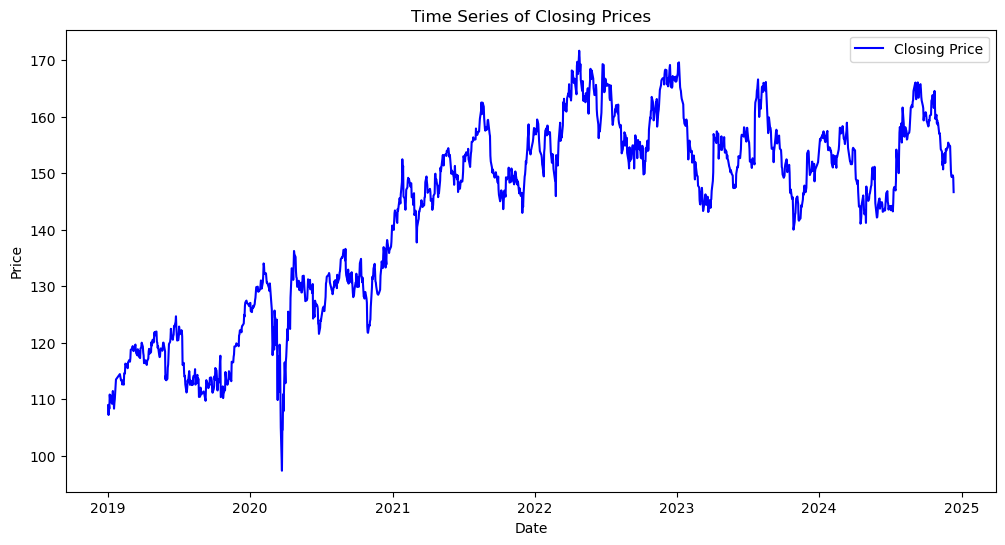

In [10]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['close'], label='Closing Price', color='blue')
plt.title('Time Series of Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

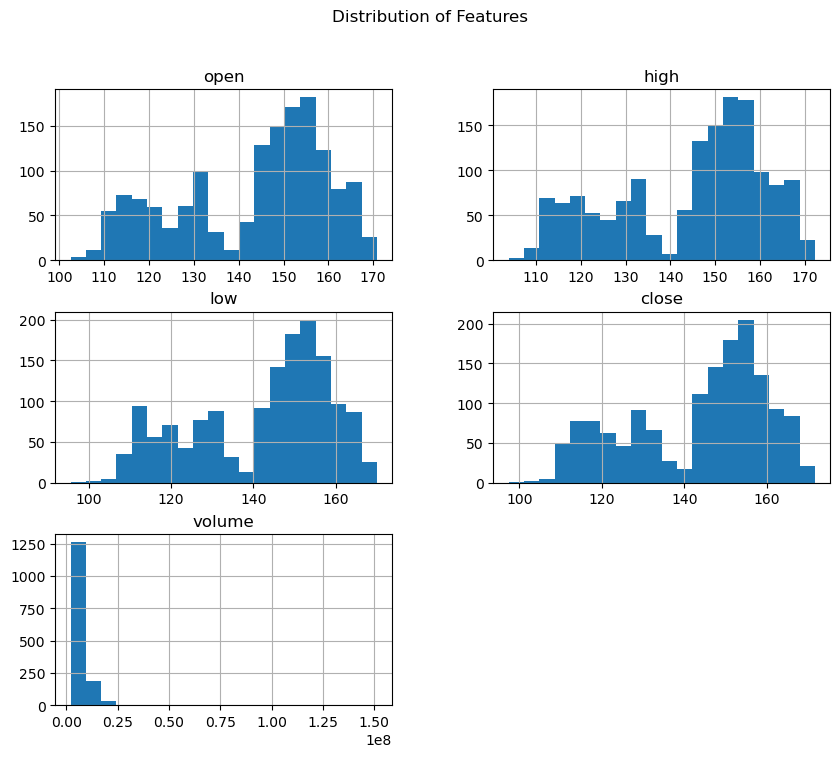

In [11]:
# Plot histograms for numerical columns
df.hist(figsize=(10, 8), bins=20)
plt.suptitle('Distribution of Features')
plt.show()

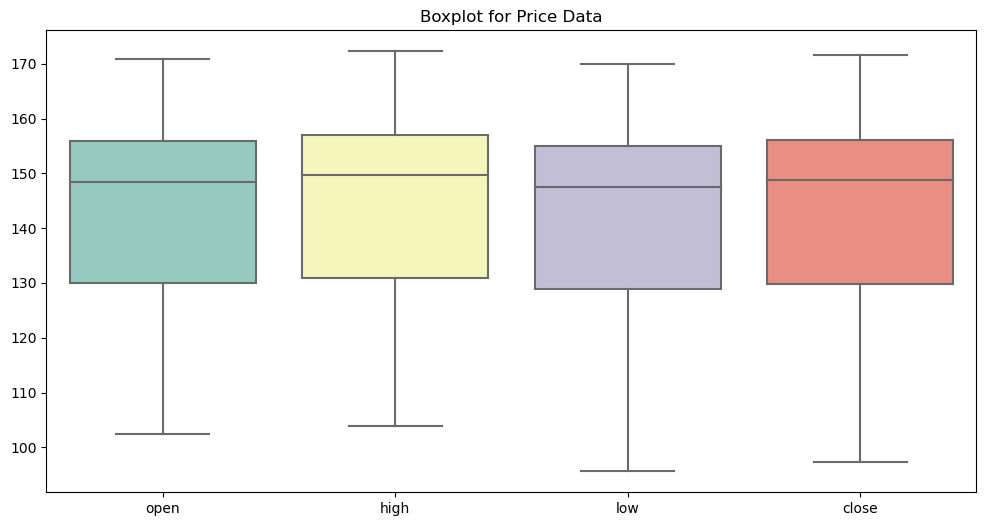

In [12]:
# Check for outliers using boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['open', 'high', 'low', 'close']], palette='Set3')
plt.title('Boxplot for Price Data')
plt.show()

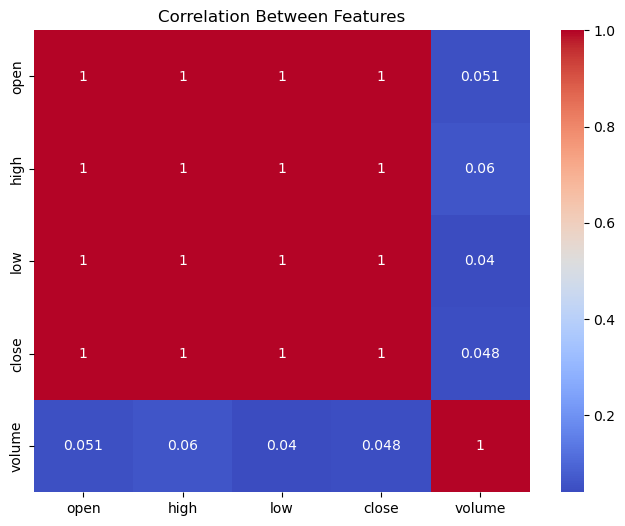

In [13]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Features')
plt.show()

In [14]:
df = df.drop(columns=['volume'], errors='ignore')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1497 entries, 2019-01-02 to 2024-12-11
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1497 non-null   float64
 1   high    1497 non-null   float64
 2   low     1497 non-null   float64
 3   close   1497 non-null   float64
dtypes: float64(4)
memory usage: 58.5 KB


# Check data for stationarity with the ADF testing

In [16]:
# Perform stationarity test using Augmented Dickey-Fuller (ADF) test
result = adfuller(df['close'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value}")

if result[1] <= 0.05:
    print("The data is stationary (reject the null hypothesis).")
else:
    print("The data is non-stationary (fail to reject the null hypothesis).")

ADF Statistic: -2.35153837520243
p-value: 0.15588386317527325
Critical Values:
	1%: -3.4347582315402434
	5%: -2.863486949792871
	10%: -2.567806534528638
The data is non-stationary (fail to reject the null hypothesis).


# Check data for seasonality

In [17]:
# Function to check seasonality for all columns (except 'date')
def check_seasonality(data, period):
    """
    Checks seasonality for all columns in a dataset where the date is already set as the index.

    Parameters:
    data (pd.DataFrame): The input dataset with a datetime index.
    period (int): The period for seasonality (e.g., 365 for daily data with yearly seasonality).

    Returns:
    None
    """
    for column in data.columns:
        print(f"\nAnalyzing column: {column}")

        try:
            # Decompose the time series
            decomposition = seasonal_decompose(data[column], model='additive', period=period)

            # Plot the decomposition
            decomposition.plot()
            plt.suptitle(f"Decomposition of {column}", fontsize=10)
            plt.show()

            # Check if the seasonal component has significant variation
            seasonal_std = decomposition.seasonal.std()

            if seasonal_std > 0.01:  # Threshold for detecting seasonality
                print(f"The column '{column}' exhibits seasonality.")
            else:
                print(f"The column '{column}' does not exhibit strong seasonality.")

        except Exception as e:
            print(f"Could not analyze column '{column}': {e}")


Analyzing column: open


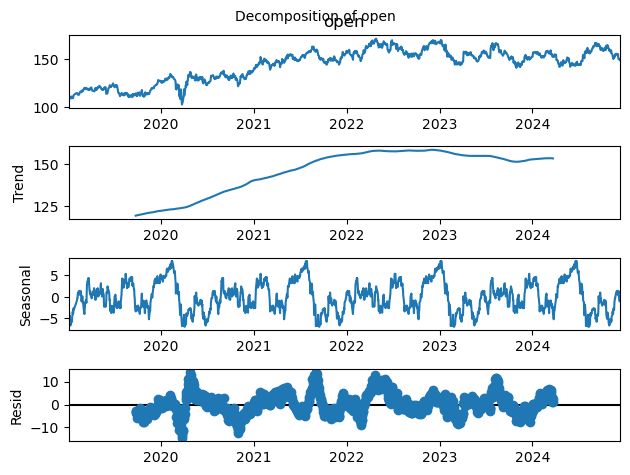

The column 'open' exhibits seasonality.

Analyzing column: high


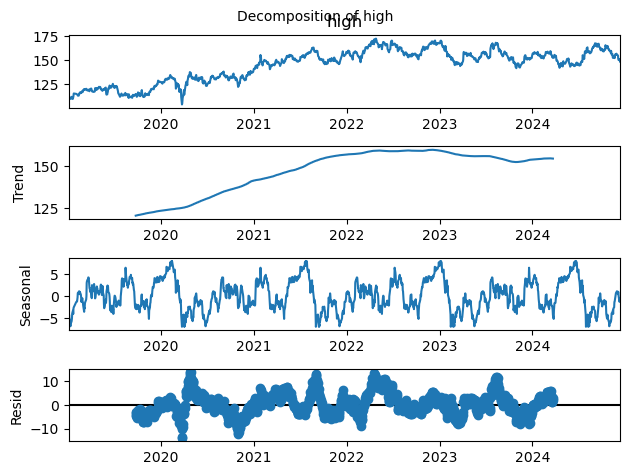

The column 'high' exhibits seasonality.

Analyzing column: low


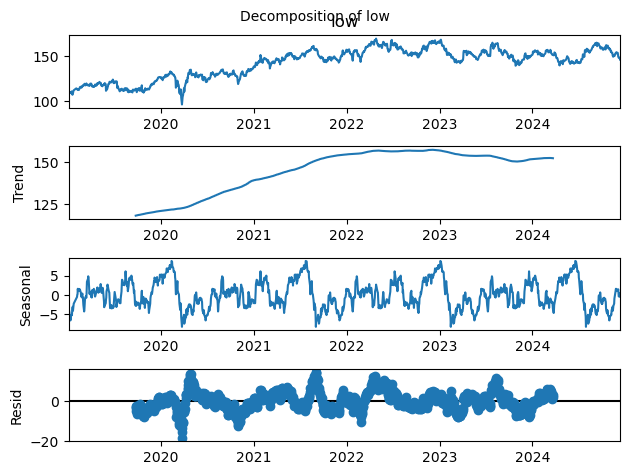

The column 'low' exhibits seasonality.

Analyzing column: close


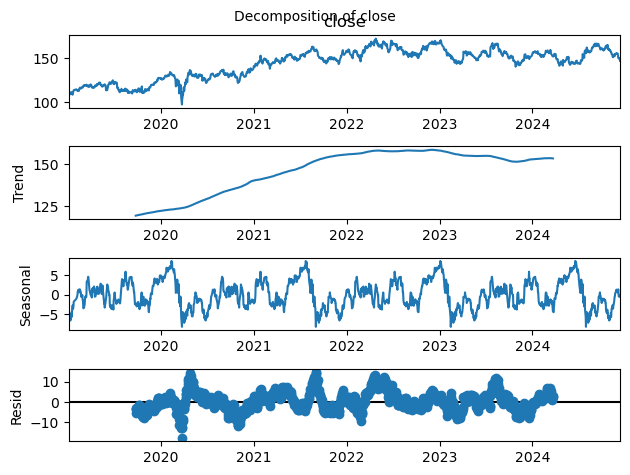

The column 'close' exhibits seasonality.


In [18]:
# Call the function to check seasonality
check_seasonality(df, period=365)


Seasonality:

From the decomposition, the seasonal component indicates the presence of little seasonal patterns in the data.
However,we will remove it, using (seasonal differencing) to make our data nonseasonal.

In [19]:
# Function to remove seasonality from all columns
def remove_seasonality(data, period):
    """
    Removes seasonality and residual seasonality from all columns in the dataset.

    Parameters:
    data (pd.DataFrame): The input dataset with a datetime index.
    period (int): The period for seasonality (e.g., 365 for daily data with yearly seasonality).

    Returns:
    pd.DataFrame: A DataFrame with seasonality removed from all columns.
    """
    nonseasonal_data = pd.DataFrame(index=data.index)

    for column in data.columns:
        print(f"\nRemoving seasonality from column: {column}")

        try:
            # Decompose the time series
            decomposition = seasonal_decompose(data[column], model='additive', period=period)

            # Remove both seasonal and residual seasonality by differencing
            nonseasonal_data[column] = data[column] - decomposition.seasonal
            nonseasonal_data[column] = nonseasonal_data[column].diff().dropna()

        except Exception as e:
            print(f"Could not remove seasonality from column '{column}': {e}")

    return nonseasonal_data

In [20]:
# Call the function to remove seasonality
nonseasonal_df = remove_seasonality(df, period=365)
print("Seasonality removed from all columns.")


Removing seasonality from column: open

Removing seasonality from column: high

Removing seasonality from column: low

Removing seasonality from column: close
Seasonality removed from all columns.


In [21]:
nonseasonal_df

,open,high,low,close
date,,,,
2019-01-02,NaN,NaN,NaN,NaN
2019-01-03,-0.882509,-0.779251,-1.694207,-2.690369
2019-01-04,-1.407151,0.126515,1.430436,2.491962
2019-01-05,1.655704,0.588699,0.442123,-0.584831
2019-01-06,0.024058,1.953616,1.550775,3.984749
...,...,...,...,...
2024-12-05,-1.882690,-0.553653,0.081355,-0.148943
2024-12-06,0.284431,0.163491,0.378953,0.814186
2024-12-09,1.201242,2.002871,0.161068,0.407990


Lets test the nonseasonality component now

In [22]:
# Function to test for nonseasonality
def test_nonseasonality(data):
    """
    Tests each column in the dataset for nonseasonality using the Augmented Dickey-Fuller (ADF) test.

    Parameters:
    data (pd.DataFrame): The dataset to test.

    Returns:
    None
    """
    for column in data.columns:
        print(f"\nTesting column: {column} for nonseasonality")

        try:
            adf_result = adfuller(data[column].dropna())
            p_value = adf_result[1]
            print(f"ADF Statistic: {adf_result[0]:.5f}, p-value: {p_value:.5f}")

            if p_value <= 0.05:
                print(f"The column '{column}' is stationary and nonseasonal.")
            else:
                print(f"The column '{column}' is still non-stationary, further processing may be required.")

        except Exception as e:
            print(f"Could not test column '{column}': {e}")

In [23]:
# Test the nonseasonal DataFrame for nonseasonality
test_nonseasonality(nonseasonal_df)


Testing column: open for nonseasonality
ADF Statistic: -39.44499, p-value: 0.00000
The column 'open' is stationary and nonseasonal.

Testing column: high for nonseasonality
ADF Statistic: -22.83658, p-value: 0.00000
The column 'high' is stationary and nonseasonal.

Testing column: low for nonseasonality
ADF Statistic: -11.43417, p-value: 0.00000
The column 'low' is stationary and nonseasonal.

Testing column: close for nonseasonality
ADF Statistic: -11.59582, p-value: 0.00000
The column 'close' is stationary and nonseasonal.


# The dataset is now nonseasonal

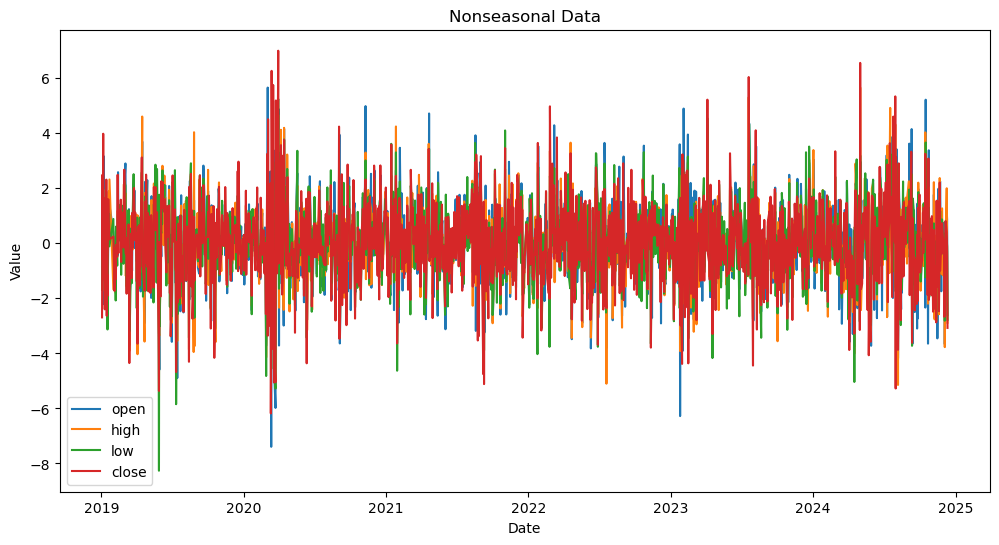

In [24]:
# Plot the nonseasonal data
plt.figure(figsize=(12, 6))
for column in nonseasonal_df.columns:
    plt.plot(nonseasonal_df.index, nonseasonal_df[column], label=column)
plt.title("Nonseasonal Data")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

# Box-Jenkins models 

<Figure size 1200x600 with 0 Axes>

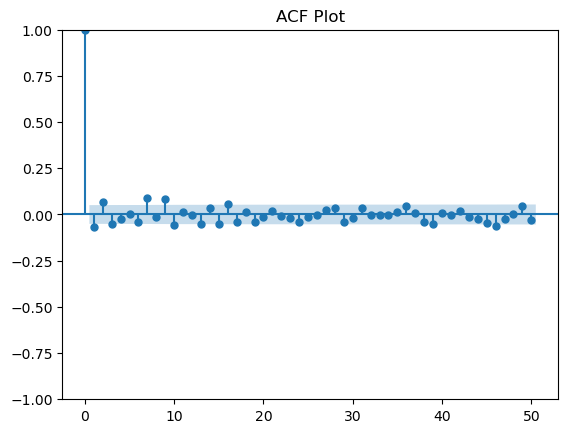

D:\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

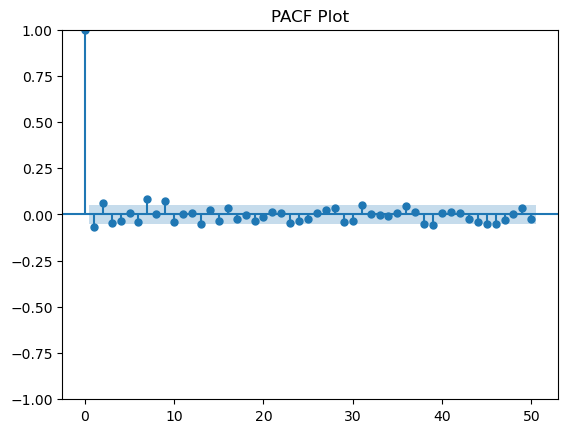

In [25]:
# choose target = close price 
target_column = 'close'

# Step 1: Plot ACF and PACF
plt.figure(figsize=(12, 6))
plot_acf(nonseasonal_df[target_column].dropna(), lags=50)
plt.title("ACF Plot")
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(nonseasonal_df[target_column].dropna(), lags=50)
plt.title("PACF Plot")
plt.show()

ACF Plot:

The autocorrelation at lag 0 is always 1.
After lag 1, the autocorrelation drops off sharply and becomes statistically insignificant (within the confidence interval, represented by the shaded region). This behavior suggests an AR(1) or ARIMA(p, d, 0) model.

PACF Plot:

The partial autocorrelation drops sharply after lag 1 and remains within the confidence interval for subsequent lags. This confirms the presence of an AR(1) component.

In [26]:
# Fit the first ARIMA model
model_1 = ARIMA(nonseasonal_df['close'].dropna(), order=(1, 1, 0))
model_fit_1 = model_1.fit()

print(model_fit_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1496
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2996.099
Date:                Sat, 14 Dec 2024   AIC                           5996.199
Time:                        20:49:01   BIC                           6006.819
Sample:                             0   HQIC                          6000.156
                               - 1496                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5635      0.017    -33.914      0.000      -0.596      -0.531
sigma2         3.2221      0.080     40.411      0.000       3.066       3.378
Ljung-Box (L1) (Q):                  38.50   Jarque-

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# residual analysis

In [27]:
# Residuals
residuals = model_fit_1.resid

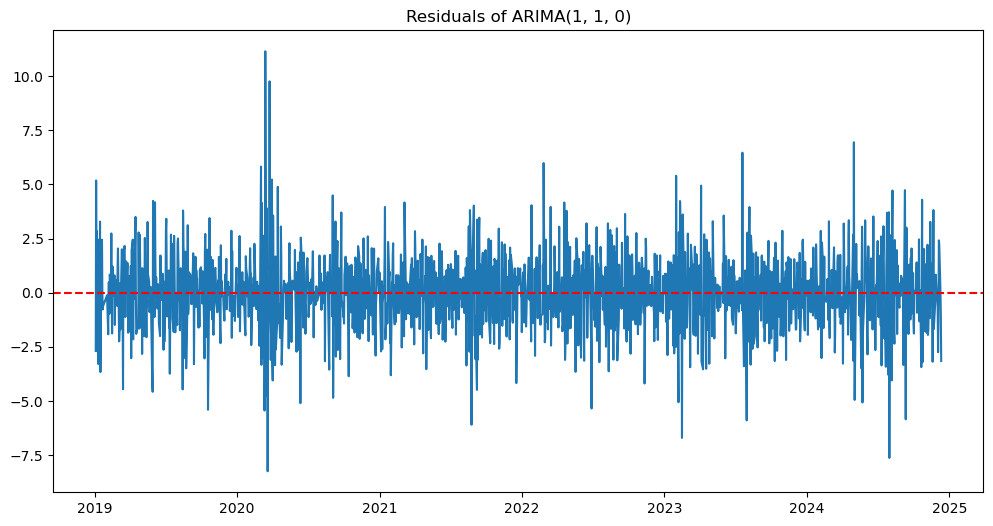

In [28]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals of ARIMA(1, 1, 0)")
plt.show()



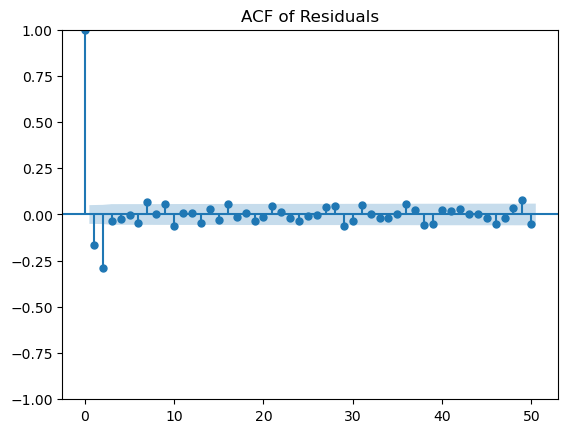

In [29]:
# Plot ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=50)
plt.title("ACF of Residuals")
plt.show()



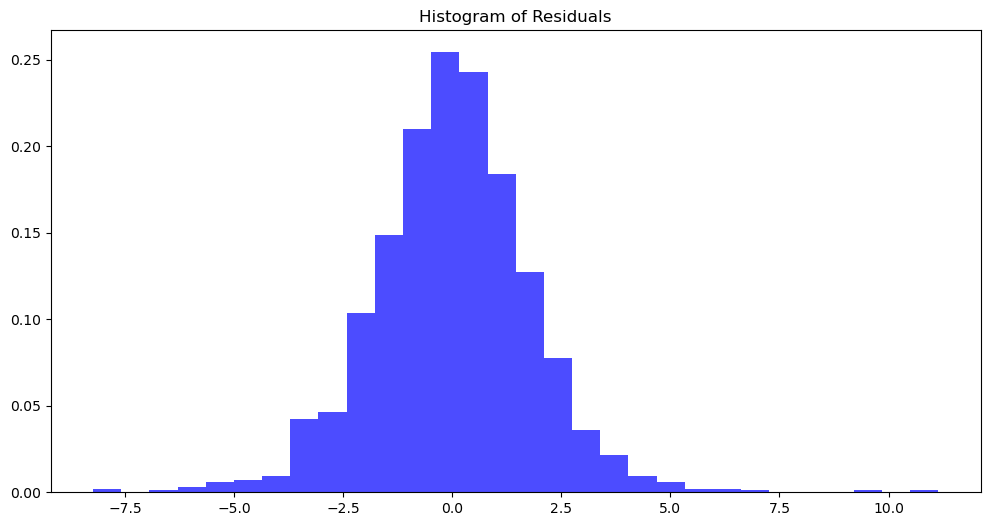

In [30]:
# Histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, density=True, alpha=0.7, color='blue')
plt.title("Histogram of Residuals")
plt.show()



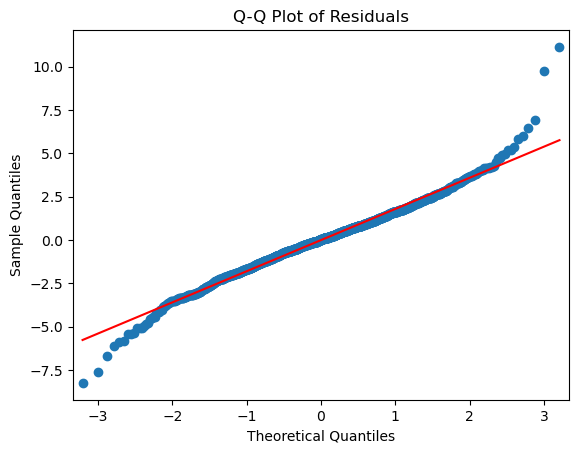

In [31]:
# Q-Q plot for normality
import statsmodels.api as sm
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

The spikes in residuals suggest that the ARIMA(1, 1, 0) model might not fully explain the data. we can try increasing the AR or adding an MA component:
Test ARIMA(2, 1, 0) or ARIMA(1, 1, 1).

Transform the Data:

The deviations in the residual histogram and Q-Q plot may indicate heteroscedasticity (changing variance). Apply a transformation (e.g., log transformation) to stabilize variance:

In [32]:
nonseasonal_df['close_log'] = np.log(nonseasonal_df['close'])

D:\anaconda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [33]:
# Fit ARIMA using pmdarima's auto_arima
print("Running Auto ARIMA to find the best model with differencing...")
auto_model = pm.auto_arima(nonseasonal_df[target_column].dropna(),
                           start_p=0, start_q=0,       # Initial AR and MA orders
                           max_p=10, max_q=10,          # Maximum AR and MA orders
                           d=None,                   # Let auto_arima find the differencing order
                           seasonal=False,           # No seasonality in this case
                           stepwise=False,            # Stepwise search to speed up the process
                           trace=True,               # Display the search process
                           suppress_warnings=True,   # Suppress convergence warnings
                           test='adf',               # Use Augmented Dickey-Fuller test for differencing
                           alpha=0.05)              # Significance level for stationarity test

print(f"Selected Model: {auto_model.summary()}")


Running Auto ARIMA to find the best model with differencing...
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5435.779, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5431.808, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5427.834, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5425.124, Time=0.10 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=5426.981, Time=0.10 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=5428.866, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5431.057, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5427.856, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5427.249, Time=0.29 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=5426.923, Time=0.29 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=5425.302, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5426.982, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5427.668, Time=0.23 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5406.572, Time=0.58 sec
 ARIMA(2,0,3)

this analysis is suggesting that Best model:  ARIMA(2,0,2)(0,0,0)[0] is the best model for this dataset but it still has high AIC value

In [34]:
# Fit the second ARIMA model
model_2 = ARIMA(nonseasonal_df['close'].dropna(), order=(2, 0, 2))
model_fit_2 = model_2.fit()

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [35]:
# Extract metrics for each model
results = {
    "Model": ["ARIMA(1, 1, 0)", "ARIMA(2, 0, 2)"],
    "AIC": [model_fit_1.aic, model_fit_2.aic],
    "BIC": [model_fit_1.bic, model_fit_2.bic],
    "Log Likelihood": [model_fit_1.llf, model_fit_2.llf]
}

# Create a DataFrame to display the results
comparison_df = pd.DataFrame(results)

# Sort by AIC for easier comparison
comparison_df = comparison_df.sort_values(by="AIC")

# Display the comparison table
print(comparison_df)

            Model          AIC          BIC  Log Likelihood
1  ARIMA(2, 0, 2)  5408.221257  5440.084558    -2698.110629
0  ARIMA(1, 1, 0)  5996.198812  6006.818575    -2996.099406


The ARIMA(2, 0, 2) model is superior to the ARIMA(1, 1, 0) model based on all evaluation metrics (AIC, BIC, and Log-Likelihood). The ARIMA(2, 0, 2) model has a much lower AIC (5408.22) compared to ARIMA(1, 1, 0) (5996.20). A lower AIC indicates a better model fit with a balance between goodness-of-fit and model complexity.

The ARIMA(2, 0, 2) model has a lower BIC (5440.08) compared to ARIMA(1, 1, 0) (6006.82).
Interpretation: BIC penalizes more complex models. A lower BIC indicates a better model with less overfitting.

The ARIMA(2, 0, 2) model has a higher log-likelihood value (-2698.11) compared to ARIMA(1, 1, 0) (-2996.10).
Interpretation: A higher log-likelihood indicates that the model explains the data better.

Therefore we will move ahead with ARIMA(2,0,2)

# FORECAST

In [36]:
# Fit the ARIMA(2, 0, 2) model
model = ARIMA(nonseasonal_df['close'].dropna(), order=(2, 0, 2))
model_fit = model.fit()


# Forecast the next steps 
forecast_steps = 30
forecast = model_fit.get_forecast(steps=forecast_steps)

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [37]:
# Extract forecasted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

In [38]:
# Create a new DatetimeIndex for the forecast
last_date = nonseasonal_df.index[-1]
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='D')[1:]  # Adjust 'D' to your dataset frequency

In [39]:
# Assign the index to the forecasted mean and confidence intervals
forecast_mean.index = forecast_index
forecast_conf_int.index = forecast_index

Forecasted Values:
2024-12-12    0.047045
2024-12-13    0.008697
2024-12-14    0.021907
2024-12-15    0.036098
2024-12-16   -0.001934
2024-12-17    0.051429
2024-12-18   -0.005700
2024-12-19    0.043075
2024-12-20    0.012760
2024-12-21    0.018609
2024-12-22    0.037951
2024-12-23   -0.001983
2024-12-24    0.049699
2024-12-25   -0.002594
2024-12-26    0.039276
2024-12-27    0.016437
2024-12-28    0.015827
2024-12-29    0.039272
2024-12-30   -0.001593
2024-12-31    0.047717
2025-01-01    0.000530
2025-01-02    0.035693
2025-01-03    0.019716
2025-01-04    0.013538
2025-01-05    0.040109
2025-01-06   -0.000832
2025-01-07    0.045551
2025-01-08    0.003614
2025-01-09    0.032359
2025-01-10    0.022591
Freq: D, Name: predicted_mean, dtype: float64


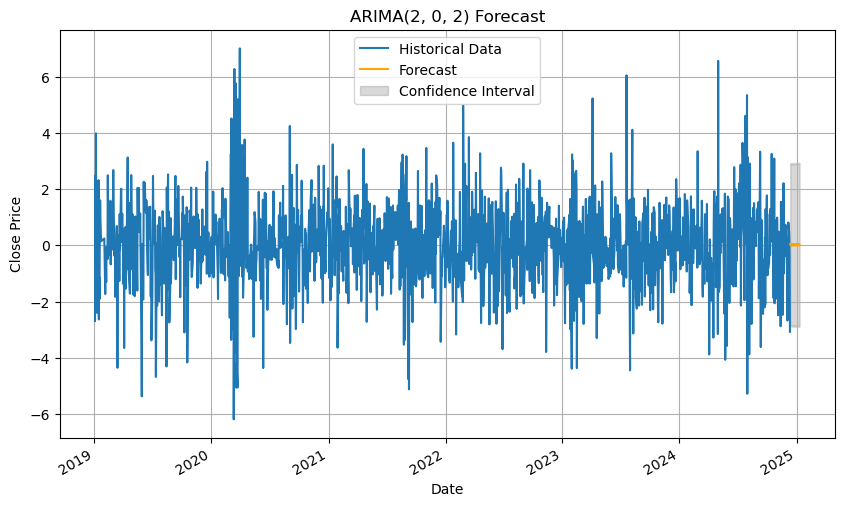

In [40]:
# Print the forecasted values
print("Forecasted Values:")
print(forecast_mean)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot historical data
nonseasonal_df['close'].plot(label='Historical Data', legend=True)

# Plot forecasted mean
forecast_mean.plot(label='Forecast', color='orange', legend=True)

# Plot confidence intervals
plt.fill_between(
    forecast_conf_int.index,
    forecast_conf_int.iloc[:, 0],  # Lower bound
    forecast_conf_int.iloc[:, 1],  # Upper bound
    color='gray', alpha=0.3, label='Confidence Interval'
)

plt.title("ARIMA(2, 0, 2) Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

<AxesSubplot:>

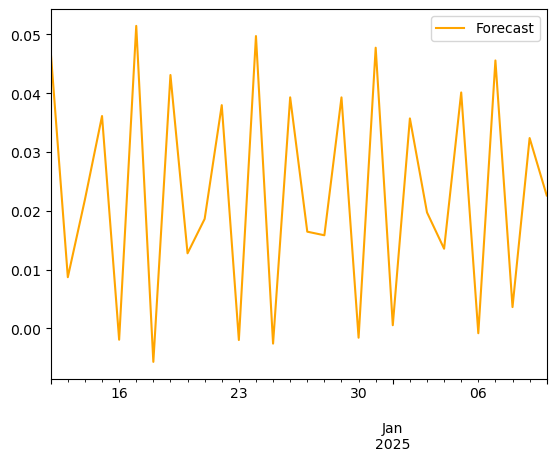

In [41]:
# Plot forecasted mean
forecast_mean.plot(label='Forecast', color='orange', legend=True)

# Conclusion

The ARIMA(2, 0, 2) model is a good choice for datasets with non-seasonal, short-term dependencies. It produces reliable forecasts with reasonable uncertainty and aligns well with historical patterns. However, it requires further enhancements to better capture high volatility or irregular spikes in the data.

# Seasonal Dataset Analysis 

In [42]:
# Read the CSV file into a DataFrame
df = pd.read_csv('testset.csv')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100990 entries, 0 to 100989
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   datetime_utc  100990 non-null  object 
 1    _conds       100918 non-null  object 
 2    _dewptm      100369 non-null  float64
 3    _fog         100990 non-null  int64  
 4    _hail        100990 non-null  int64  
 5    _heatindexm  29155 non-null   float64
 6    _hum         100233 non-null  float64
 7    _precipm     0 non-null       float64
 8    _pressurem   100758 non-null  float64
 9    _rain        100990 non-null  int64  
 10   _snow        100990 non-null  int64  
 11   _tempm       100317 non-null  float64
 12   _thunder     100990 non-null  int64  
 13   _tornado     100990 non-null  int64  
 14   _vism        96562 non-null   float64
 15   _wdird       86235 non-null   float64
 16   _wdire       86235 non-null   object 
 17   _wgustm      1072 non-null    float64
 18   _wi

In [44]:
# Convert `datetime_utc` to datetime format and set it as the index
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'], errors='coerce')  # Convert to datetime
df.set_index('datetime_utc', inplace=True)  # Set as index

In [45]:
df.columns = df.columns.str.strip().str.lower()  # Strip spaces and convert to lowercase
print(df.columns)  # Verify cleaned column names


Index(['_conds', '_dewptm', '_fog', '_hail', '_heatindexm', '_hum', '_precipm',
       '_pressurem', '_rain', '_snow', '_tempm', '_thunder', '_tornado',
       '_vism', '_wdird', '_wdire', '_wgustm', '_windchillm', '_wspdm'],
      dtype='object')


In [46]:
# Drop all columns except `_rain` and `_tempm`, and rename them
df = df[['_tempm', '_rain']]  # Select the required columns
df.rename(columns={'_tempm': 'tempm', '_rain': 'rain'}, inplace=True)  # Rename columns



# Remove rows with null values
df = df.dropna()

In [47]:
df.head()

,tempm,rain
datetime_utc,,
1996-11-01 11:00:00,30.0,0
1996-11-01 12:00:00,28.0,0
1996-11-01 13:00:00,24.0,0
1996-11-01 14:00:00,24.0,0
1996-11-01 16:00:00,23.0,0


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100317 entries, 1996-11-01 11:00:00 to 2017-04-24 18:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   tempm   100317 non-null  float64
 1   rain    100317 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 2.3 MB


In [49]:
# Summary statistics
df.describe()

,tempm,rain
count,100317.000000,100317.000000
mean,25.451269,0.026247
std,8.482859,0.159869
min,1.000000,0.000000
25%,19.000000,0.000000
50%,27.000000,0.000000
75%,32.000000,0.000000
max,90.000000,1.000000


In [50]:
# Missing values
df.isnull().sum()

tempm    0
rain     0
dtype: int64

In [51]:
# Resampling for trends and seasonality (monthly mean)
monthly_avg = df.resample('M').mean()
print(monthly_avg)

                  tempm      rain
datetime_utc                     
1996-11-30    19.438944  0.000000
1996-12-31    13.816794  0.000000
1997-01-31    12.871118  0.007764
1997-02-28    15.778777  0.005396
1997-03-31    21.137037  0.012963
...                 ...       ...
2016-12-31    17.733945  0.000000
2017-01-31    15.776730  0.034591
2017-02-28    18.414062  0.000000
2017-03-31    23.553459  0.022013
2017-04-30    30.775120  0.009569

[246 rows x 2 columns]


In [52]:
# Yearly averages for seasonality
yearly_avg = df.resample('Y').mean()
print(yearly_avg)

                  tempm      rain
datetime_utc                     
1996-12-31    16.518636  0.000000
1997-12-31    24.444635  0.030482
1998-12-31    24.847371  0.039570
1999-12-31    27.335731  0.016307
2000-12-31    23.865647  0.020153
2001-12-31    25.582460  0.017227
2002-12-31    26.481948  0.016983
2003-12-31    26.176556  0.023368
2004-12-31    26.004396  0.013738
2005-12-31    24.712715  0.047423
2006-12-31    25.449245  0.035125
2007-12-31    24.800211  0.040028
2008-12-31    24.525744  0.047986
2009-12-31    25.355360  0.031634
2010-12-31    25.553338  0.049347
2011-12-31    24.966362  0.033638
2012-12-31    25.024661  0.031237
2013-12-31    24.679222  0.031457
2014-12-31    25.175735  0.026698
2015-12-31    25.141832  0.038961
2016-12-31    27.315734  0.028290
2017-12-31    20.204369  0.021846


# Exploratory Data Analysis

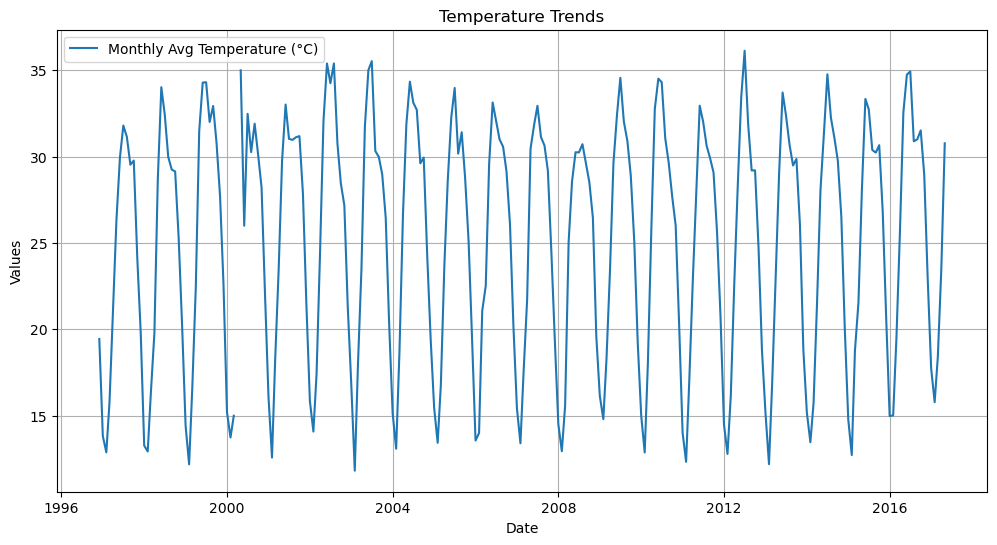

In [53]:
# Line plot for temperature and rainfall trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg["tempm"], label="Monthly Avg Temperature (°C)")
plt.title("Temperature Trends")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()

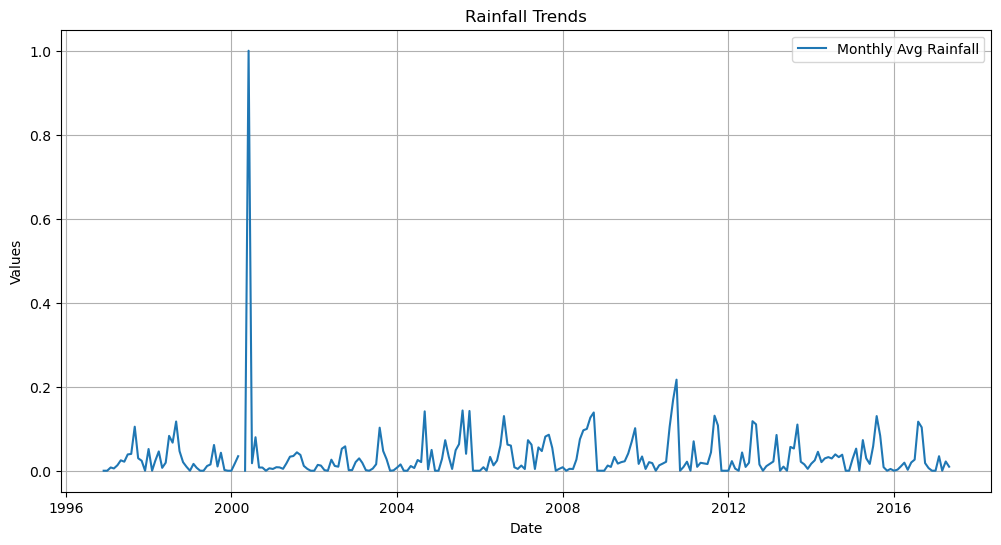

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg["rain"], label="Monthly Avg Rainfall")
plt.title("Rainfall Trends")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()

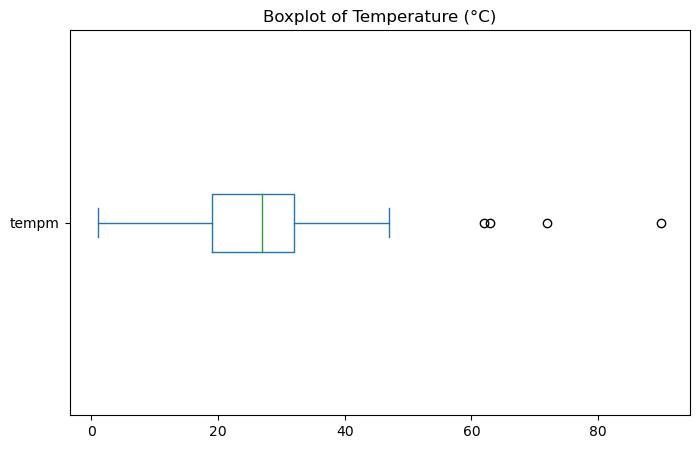

In [55]:
# Boxplot for temperature to identify outliers
plt.figure(figsize=(8, 5))
df["tempm"].plot(kind="box", vert=False)
plt.title("Boxplot of Temperature (°C)")
plt.show()

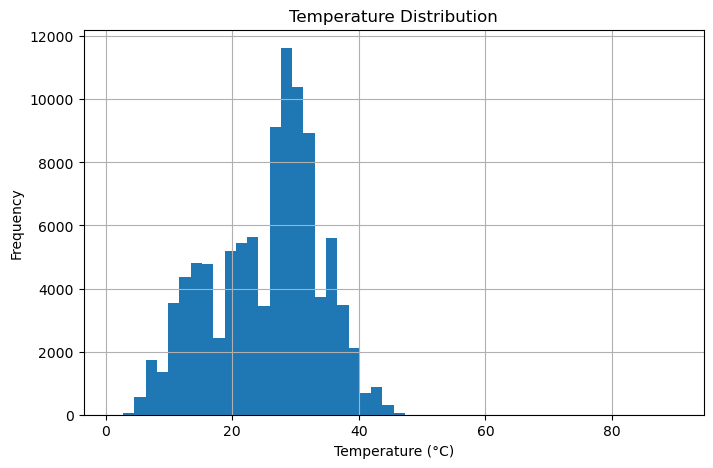

In [56]:
# Distribution histograms
df["tempm"].hist(bins=50, figsize=(8, 5))
plt.title("Temperature Distribution")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

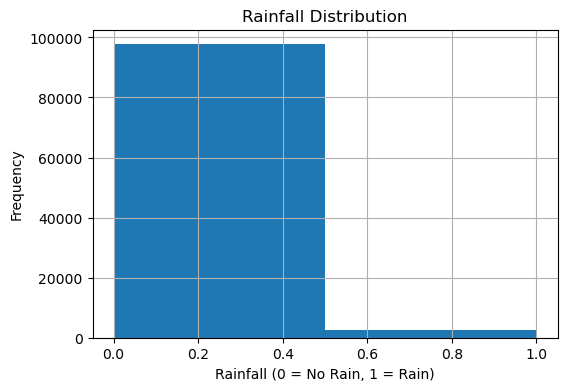

In [57]:
df["rain"].hist(bins=2, figsize=(6, 4))
plt.title("Rainfall Distribution")
plt.xlabel("Rainfall (0 = No Rain, 1 = Rain)")
plt.ylabel("Frequency")
plt.show()

# check seasonality and stationarity 

In [58]:
# Resample the data to daily for better seasonality and stationarity testing
daily_temp = df["tempm"].resample('D').mean()
daily_rain = df["rain"].resample('D').mean()

# Ensure both series have a proper DatetimeIndex
daily_temp.index = pd.to_datetime(daily_temp.index)
daily_rain.index = pd.to_datetime(daily_rain.index)

In [59]:
# Concatenate the two resampled series into a single DataFrame
resampled_df = pd.concat([daily_temp, daily_rain], axis=1)

# Rename the columns for clarity
resampled_df.columns = ['tempm', 'rain']

# Ensure the index is a DatetimeIndex 
resampled_df.index = pd.to_datetime(resampled_df.index)

# Display the first few rows of the concatenated DataFrame
print(resampled_df.head())

                  tempm  rain
datetime_utc                 
1996-11-01    22.333333   0.0
1996-11-02    22.916667   0.0
1996-11-03    21.791667   0.0
1996-11-04    22.722222   0.0
1996-11-05    27.800000   0.0


In [60]:
# Function to perform the Augmented Dickey-Fuller test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = dict(zip(labels, result[:4]))
    for key, val in out.items():
        print(f'{key}: {val}')
    print("Critical Values:")
    for key, val in result[4].items():
        print(f'\t{key}: {val}')
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

In [61]:
# Test for stationarity in temperature data
print("Testing Temperature Data for Stationarity:")
adf_test(daily_temp, title="Daily Temperature")

Testing Temperature Data for Stationarity:
Augmented Dickey-Fuller Test: Daily Temperature
ADF Statistic: -7.385299389884953
p-value: 8.267160514254464e-11
#Lags Used: 36
Number of Observations Used: 7299
Critical Values:
	1%: -3.4312462325329602
	5%: -2.861936065328268
	10%: -2.566980821324461
The series is stationary.


In [62]:
# Test for stationarity in rainfall data
print("\nTesting Rainfall Data for Stationarity:")
adf_test(daily_rain, title="Daily Rainfall")


Testing Rainfall Data for Stationarity:
Augmented Dickey-Fuller Test: Daily Rainfall
ADF Statistic: -10.173850131308416
p-value: 6.975432877154501e-18
#Lags Used: 30
Number of Observations Used: 7305
Critical Values:
	1%: -3.4312454961487617
	5%: -2.8619357399525454
	10%: -2.566980648121991
The series is stationary.


In [63]:
def check_seasonality(data, period, fill_method='linear'):
    """
    Checks seasonality for all columns in a dataset where the date is already set as the index.

    Parameters:
    data (pd.DataFrame): The input dataset with a datetime index.
    period (int): The period for seasonality (e.g., 365 for daily data with yearly seasonality).
    fill_method (str): The method to handle missing values ('linear', 'ffill', 'bfill', or 'mean').

    Returns:
    None
    """
    for column in data.columns:
        print(f"\nAnalyzing column: {column}")

        try:
            # Ensure the column is numeric for decomposition
            if data[column].dtype in ['float64', 'int64']:
                # Handle missing values
                if fill_method == 'linear':
                    column_data = data[column].interpolate(method='linear')
                elif fill_method == 'ffill':
                    column_data = data[column].fillna(method='ffill')
                elif fill_method == 'bfill':
                    column_data = data[column].fillna(method='bfill')
                elif fill_method == 'mean':
                    column_data = data[column].fillna(data[column].mean())
                else:
                    raise ValueError("Invalid fill_method. Choose from 'linear', 'ffill', 'bfill', or 'mean'.")

                # Decompose the time series
                decomposition = seasonal_decompose(column_data, model='additive', period=period)

                # Plot the decomposition
                decomposition.plot()
                plt.suptitle(f"Decomposition of {column}", fontsize=5)
                plt.show()

                # Check if the seasonal component has significant variation
                seasonal_std = decomposition.seasonal.std()

                if seasonal_std > 0.01:  # Threshold for detecting seasonality
                    print(f"The column '{column}' exhibits seasonality.")
                else:
                    print(f"The column '{column}' does not exhibit strong seasonality.")
            else:
                print(f"Column '{column}' is not numeric and cannot be analyzed for seasonality.")

        except Exception as e:
            print(f"Could not analyze column '{column}': {e}")


Analyzing column: tempm


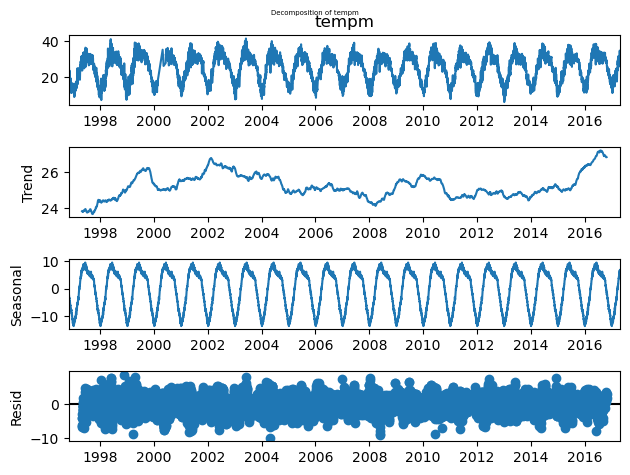

The column 'tempm' exhibits seasonality.

Analyzing column: rain


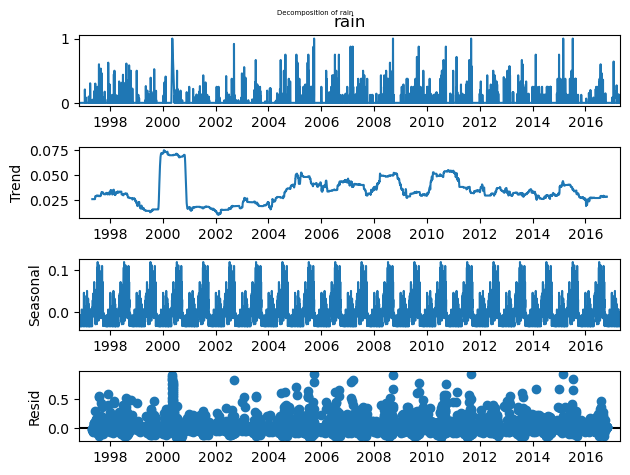

The column 'rain' exhibits seasonality.


In [64]:
check_seasonality(resampled_df, period=365)  # For yearly seasonality in daily data

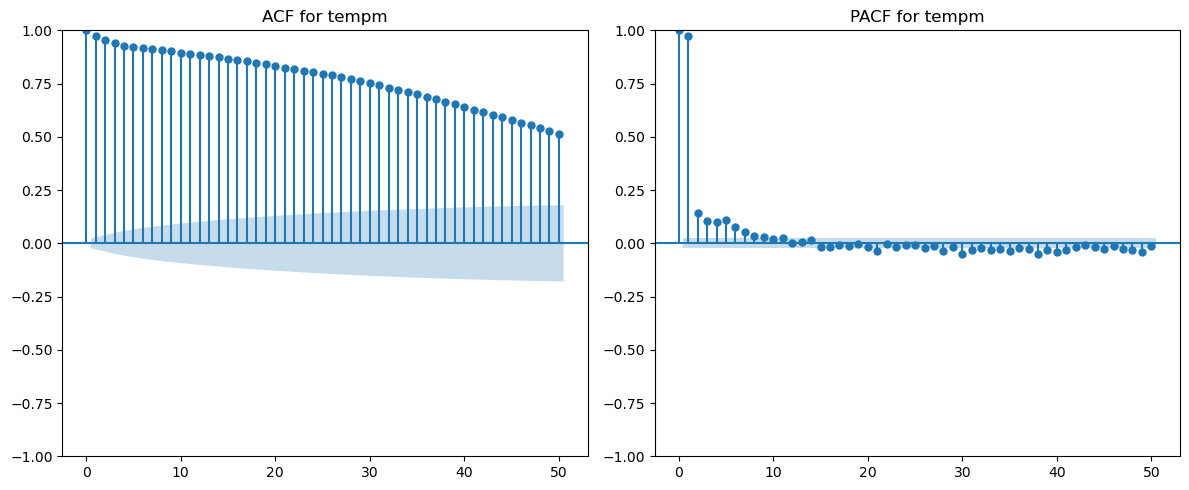

In [65]:
# Plot ACF and PACF for 'tempm' column
plt.figure(figsize=(12, 5))

# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(resampled_df['tempm'].dropna(), lags=50, ax=plt.gca())
plt.title("ACF for tempm")

# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(resampled_df['tempm'].dropna(), lags=50, ax=plt.gca(), method='ywm')
plt.title("PACF for tempm")

plt.tight_layout()
plt.show()

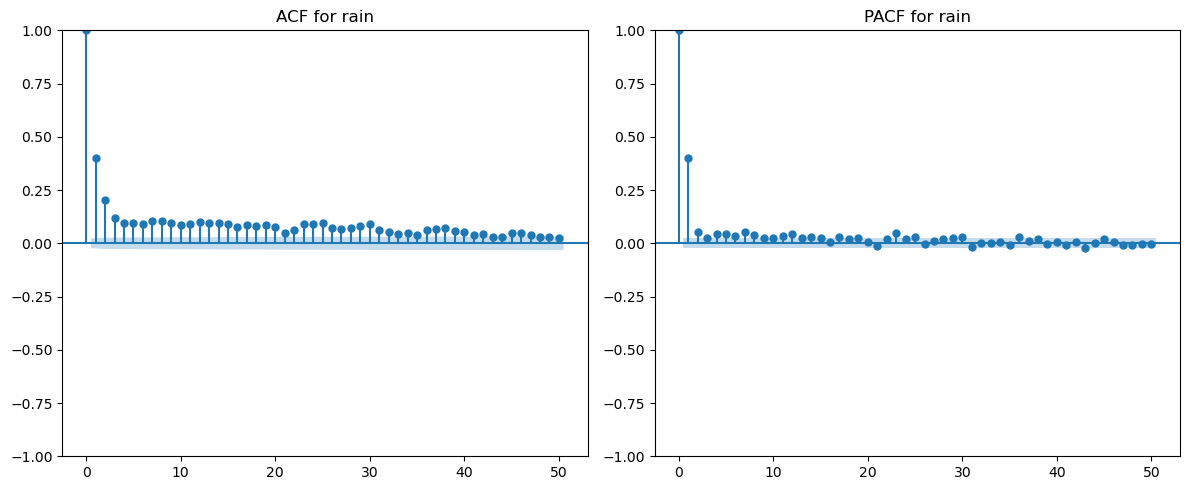

In [66]:
# Plot ACF and PACF for 'rain' column
plt.figure(figsize=(12, 5))

# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(resampled_df['rain'].dropna(), lags=50, ax=plt.gca())
plt.title("ACF for rain")

# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(resampled_df['rain'].dropna(), lags=50, ax=plt.gca(), method='ywm')
plt.title("PACF for rain")

plt.tight_layout()
plt.show()

From the ACF plot:
The slow decay suggests a possible ARIMA model with a strong autoregressive (AR) component.
The ACF doesn't cut off after a few lags, suggesting this is not a pure Moving Average (MA) process.
From the PACF plot:
The sharp cutoff after lag 1 indicates the order of the AR component (i.e., p=1).
Since PACF cuts off while ACF decays, this suggests an ARIMA(p, d, q) model where p=1, d (differencing) is needed for stationarity, and q=0.

In [67]:
# Fit the ARIMA model
model = ARIMA(resampled_df['tempm'].dropna(), order=(1, 0, 0))
fitted_model = model.fit()

# Summary of the model
print(fitted_model.summary())

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  tempm   No. Observations:                 7336
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -14460.037
Date:                Sat, 14 Dec 2024   AIC                          28926.075
Time:                        20:49:20   BIC                          28946.777
Sample:                             0   HQIC                         28933.192
                               - 7336                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.0769      0.738     33.979      0.000      23.630      26.523
ar.L1          0.9723      0.003    347.245      0.000       0.967       0.978
sigma2         3.0160      0.031     96.777      0.0

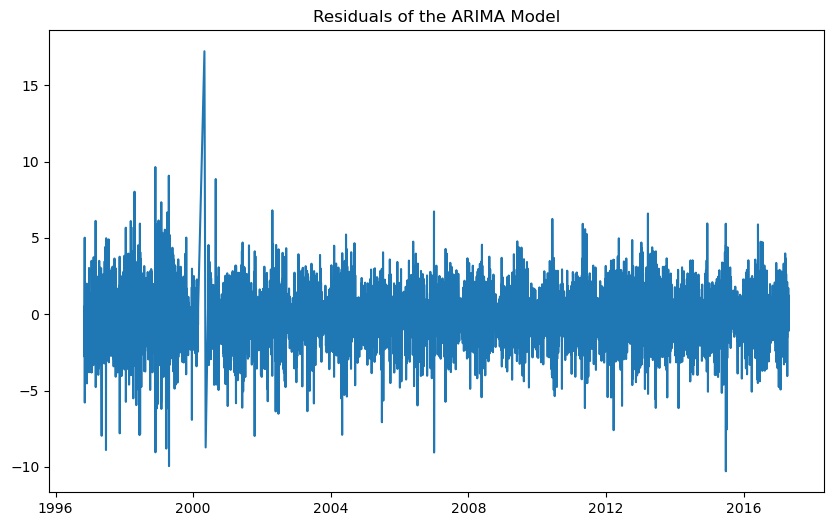

In [68]:
residuals = fitted_model.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title("Residuals of the ARIMA Model")
plt.show()

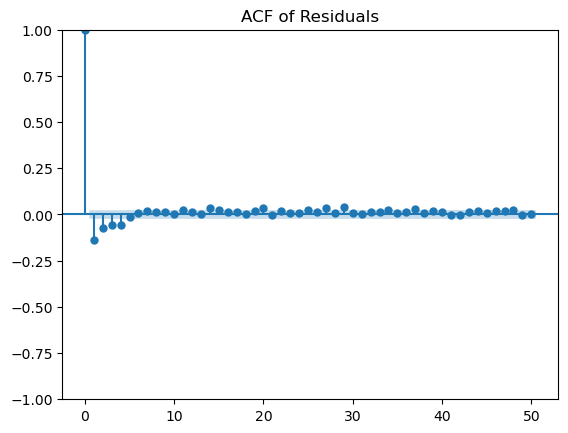

D:\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


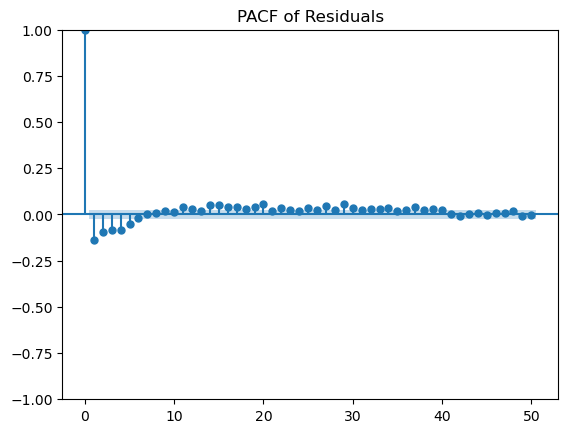

In [69]:
plot_acf(residuals, lags=50)
plt.title("ACF of Residuals")
plt.show()

plot_pacf(residuals, lags=50)
plt.title("PACF of Residuals")
plt.show()


In [70]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_results)

       lb_stat     lb_pvalue
10  231.985536  3.293049e-44


Because the above ARIMA model did not perform well, we will try fitting different models. Because this data is seasoanl, we will try making a SARIMA model. Below is the code for finding out the best SARIMA value based on the interpretation of the ACFs and PACF lag values. We will also downsize the dataset (from daily to monthly) to reduce noise. 

In [71]:
monthly_data = resampled_df['tempm'].resample('M').mean()


In [ ]:
warnings.filterwarnings("ignore")  

# Define the p, d, q and P, D, Q ranges to search
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 12  # monthly seasonality

# Create all combinations of p, d, q and seasonal P, D, Q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in itertools.product(P, D, Q)]

best_aic = float("inf")
best_model = None
best_params = None

# Grid search
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(monthly_data.dropna(), order=param, seasonal_order=seasonal_param)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_model = results
                best_params = (param, seasonal_param)
        except:
            continue

print(f"Best SARIMA Model: Order {best_params[0]} Seasonal Order {best_params[1]} with AIC {best_aic}")

Best SARIMA Model: Order (0, 0, 2) Seasonal Order (0, 1, 1, 12) with AIC 968.490129426434

The above code suggests that a SARIMA Model: Order (0, 0, 2) Seasonal Order (0, 1, 1, 12) is best suited for this dataset. Although the AIC is still quite high (968.49), when compared to the ARIMA model's AIC (28926), it is significantly low.

In [72]:
sarima_model = SARIMAX(monthly_data.dropna(), order=(0, 0, 2), seasonal_order=(0, 1, 1, 12))
sarima_fitted = sarima_model.fit()
print(sarima_fitted.summary())

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                tempm   No. Observations:                  245
Model:             SARIMAX(0, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -480.245
Date:                              Sat, 14 Dec 2024   AIC                            968.490
Time:                                      20:49:21   BIC                            982.294
Sample:                                           0   HQIC                           974.057
                                              - 245                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3120      0.034      9.095      0.000       0.245       0.379
ma.L2          0.24

# Result and Comparison of SARIMA (0,0,2)(0,1,1,12) vs ARIMA (1,0,0)

In [73]:
# Extract relevant metrics for SARIMA model
sarima_aic = sarima_fitted.aic
sarima_bic = sarima_fitted.bic
sarima_log_likelihood = sarima_fitted.llf

# Extract relevant metrics for ARIMA model
arima_aic = fitted_model.aic
arima_bic = fitted_model.bic
arima_log_likelihood = fitted_model.llf

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['SARIMA (0, 0, 2)(0, 1, 1, 12)', 'ARIMA (1, 0, 0)'],
    'AIC': [sarima_aic, arima_aic],
    'BIC': [sarima_bic, arima_bic],
    'Log Likelihood': [sarima_log_likelihood, arima_log_likelihood]
})

# Sort by AIC for better model comparison
comparison_df = comparison_df.sort_values(by='AIC')

# Display the comparison table
print(comparison_df)


                           Model           AIC           BIC  Log Likelihood
0  SARIMA (0, 0, 2)(0, 1, 1, 12)    968.490129    982.294283     -480.245065
1                ARIMA (1, 0, 0)  28926.074912  28946.776559   -14460.037456


AIC (Akaike Information Criterion):

The SARIMA model (0, 0, 2)(0, 1, 1, 12) has an AIC of 968.49, which is significantly lower than the AIC of the ARIMA model (1, 0, 0) (28926.07).
Lower AIC indicates a better model fit. Therefore, the SARIMA model is a better choice in terms of model fit.
BIC (Bayesian Information Criterion):

The SARIMA model has a BIC of 982.29, while the ARIMA model has a BIC of 28946.78.
Lower BIC also indicates a better model fit, further confirming the superiority of the SARIMA model over the ARIMA model.
Log Likelihood:

The SARIMA model has a higher log-likelihood value (-480.25) compared to the ARIMA model (-14460.04).
A higher log-likelihood indicates that the SARIMA model explains the data better.

In [74]:
# Ensure the index is a DatetimeIndex
monthly_data.index = pd.to_datetime(monthly_data.index)


In [75]:
monthly_data

datetime_utc
1996-11-30    19.548146
1996-12-31    13.795090
1997-01-31    12.863702
1997-02-28    15.936124
1997-03-31    21.292248
                ...    
2016-12-31    17.672565
2017-01-31    15.710873
2017-02-28    18.349981
2017-03-31    23.753760
2017-04-30    30.753663
Freq: M, Name: tempm, Length: 246, dtype: float64

In [86]:
# Number of steps to forecast
forecast_steps = 36  

# Forecast future values using the SARIMA model
forecast = sarima_fitted.get_forecast(steps=forecast_steps)

# Extract forecasted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Display forecasted values
print("Forecasted Values:")
print(forecast_mean)


Forecasted Values:
245    33.909501
246    34.285187
247    30.970052
248    30.665521
249    30.580599
250    27.409131
251    21.264301
252    16.053664
253    14.569438
254    18.183008
255    23.644438
256    30.351294
257    33.757358
258    34.173638
259    30.970052
260    30.665521
261    30.580599
262    27.409131
263    21.264301
264    16.053664
265    14.569438
266    18.183008
267    23.644438
268    30.351294
269    33.757358
270    34.173638
271    30.970052
272    30.665521
273    30.580599
274    27.409131
275    21.264301
276    16.053664
277    14.569438
278    18.183008
279    23.644438
280    30.351294
Name: predicted_mean, dtype: float64


D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [87]:
monthly_data = monthly_data.reset_index()
monthly_data['datetime_utc'] = pd.to_datetime(monthly_data['datetime_utc'])
monthly_data.set_index('datetime_utc', inplace=True)


In [88]:
# Get the last date from the original data
last_date = monthly_data.index[-1]

# Create a new DatetimeIndex for the forecasted steps
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='M')[1:]

# Assign the new index to the forecasted mean
forecast_mean.index = forecast_index
forecast_conf_int.index = forecast_index

<Figure size 1000x800 with 0 Axes>

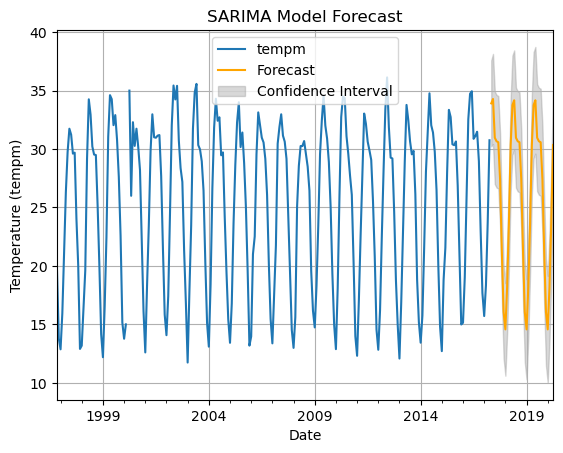

In [89]:
# Plot historical data and forecast
plt.figure(figsize=(10, 8))

# Plot the historical data
monthly_data.plot(label='Historical Data', legend=True)

# Plot the forecasted mean
forecast_mean.plot(label='Forecast', color='orange', legend=True)

# Plot confidence intervals
plt.fill_between(
    forecast_conf_int.index,
    forecast_conf_int.iloc[:, 0],  # Lower bound
    forecast_conf_int.iloc[:, 1],  # Upper bound
    color='gray', alpha=0.3, label='Confidence Interval'
)

plt.title("SARIMA Model Forecast")
plt.xlabel("Date")
plt.ylabel("Temperature (tempm)")
plt.legend()
plt.grid(True)
plt.show()

<AxesSubplot:>

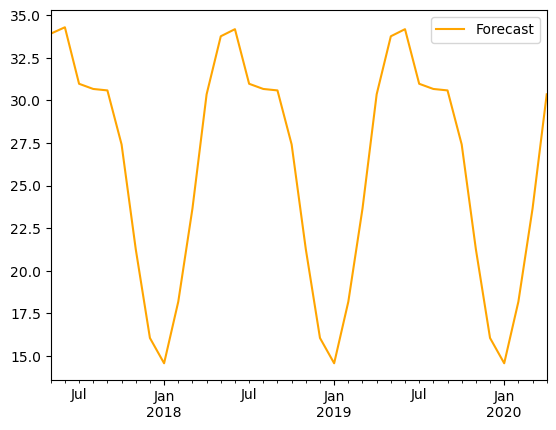

In [90]:
# Plot the forecasted mean
forecast_mean.plot(label='Forecast', color='orange', legend=True)

# Conclusion 

The SARIMA (0, 0, 2)(0, 1, 1, 12) model is a good fit for the data. From the above graphs we can say, it effectively captures the seasonal and trend components, provides accurate forecasts, and demonstrates strong performance based on evaluation metrics. 